## Python 中生成器原理

In [ ]:
def foo():
    bar()
def bar():
    pass
# python.exe 会用一个 PyEval_EvalFramEx(c函数)，去执行foo函数
# 创建 StackFrame，将代码变成字节码对象
# 当 foo 调用子函数 bar，又会创建 StackFrame
# 所有的 StackFrame 都是分配在 堆内存上
#   - 因为分配在堆内存上，所以这个函数的 StackFrame 可以独立于调用者而存在
import dis
print("dis.dis(foo) = ", dis.dis(foo))

  2           0 LOAD_GLOBAL              0 (bar)
              2 CALL_FUNCTION            0
              4 POP_TOP
              6 LOAD_CONST               0 (None)
              8 RETURN_VALUE
dis.dis(foo) =  None


In [6]:
import inspect

# 因为分配在堆内存上，所以这个函数的 StackFrame 可以独立于调用者而存在
frame = None
def foo():
    bar()

def bar():
    global frame
    frame = inspect.currentframe()

if __name__ == "__main__":
    foo()
    print("bar func frame = ", frame.f_code.co_name)
    caller_frame = frame.f_back
    print("caller_frame.f_code.co_name = ", caller_frame.f_code.co_name)
    print("frame = ", frame)

bar func frame =  bar
caller_frame.f_code.co_name =  foo
frame =  <frame at 0x7fd7e474fcc0, file '/tmp/ipykernel_1195309/4098670115.py', line 10, code bar>


![alt text](image.png)

### 生成器函数结构
- 正因为 yield 能够随时暂停，随时恢复，构成了携程的基础

In [ ]:
def gen_func():
    # 暂停函数执行
    yield 1
    name = "bobby"
    # 暂停函数执行
    yield 2
    age = 30
    return "imocc"

import dis
if __name__ == "__main__":
    # 这个 gen 对象，其实是对 python 函数 StackFrame 的封装
    gen = gen_func()
    print(dis.dis(gen))
    # 打印
    print(gen.gi_frame.f_lasti)
    print(gen.gi_frame.f_locals)
    next(gen)
    print(gen.gi_frame.f_lasti)
    print(gen.gi_frame.f_locals)
    next(gen)
    print(gen.gi_frame.f_lasti)
    print(gen.gi_frame.f_locals)

  2           0 LOAD_CONST               1 (1)
              2 YIELD_VALUE
              4 POP_TOP

  3           6 LOAD_CONST               2 ('bobby')
              8 STORE_FAST               0 (name)

  4          10 LOAD_CONST               3 (2)
             12 YIELD_VALUE
             14 POP_TOP

  5          16 LOAD_CONST               4 (30)
             18 STORE_FAST               1 (age)

  6          20 LOAD_CONST               5 ('imocc')
             22 RETURN_VALUE
None
-1
{}
2
{}
12
{'name': 'bobby'}


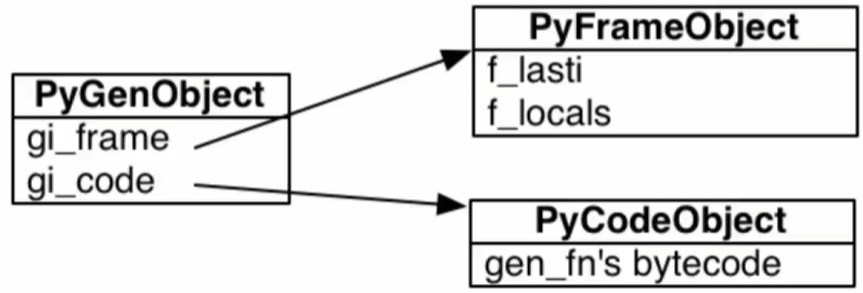

# 类比 golang 进行学习

package main

import "fmt"

// 模拟类似 Python 中的 yield
func generateFib() <-chan int {
    ch := make(chan int)
    go func() {
        a, b := 0, 1
        for {
            ch <- a // 发送数据到 channel，相当于 yield
            a, b = b, a + b
        }
    }()
    return ch
}

func main() {
    fib := generateFib()
    for i := 0; i < 10; i++ {
        fmt.Println(<-fib) // 从 channel 获取数据，相当于从 generator 恢复
    }
}
